In [1]:
import torch
import lightning as pl
from tabulate import tabulate
import matplotlib.pyplot as plt
import torchvision

from kornia import tensor_to_image
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, DeviceStatsMonitor, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.tuner import Tuner

In [2]:
class Args:
    def __init__(self, config):
        self.lr = config["lr"]
        self.working_dir_path = config["working_dir_path"]
        self.dataset_h5_path = config["dataset_h5_path"]
        self.hospitaldict_path = config["hospitaldict_path"]
        self.rseed = config["rseed"]
        self.train_ratio = config["train_ratio"]
        self.batch_size = config["batch_size"]
        self.freeze_layers = config["freeze_layers"]
        self.optimizer = config["optimizer"]
        self.lr = config["lr"]
        self.weight_decay = config["weight_decay"]
        self.momentum = config["momentum"]
        self.label_smoothing = config["label_smoothing"]
        self.max_epochs = config["max_epochs"]
        self.num_workers = config["num_workers"]
        self.accumulate_grad_batches = config["accumulate_grad_batches"]
        self.precision = config["precision"]
        self.disable_warnings = config["disable_warnings"]
        self.mixup = config["mixup"]
        self.trim_data = config["trim_data"]
        self.pretrained = config["pretrained"]
        self.version = config["version"]

In [3]:
config = {
    "working_dir_path": ".",
    "dataset_h5_path": "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5",
    "hospitaldict_path": "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl",
    # "working_dir_path": r"C:\Users\andri\Progetti\lus-dl-framework",
    # "dataset_h5_path": r"C:\Users\andri\Progetti\lus-dl-framework\data\iclus\dataset.h5",
    # "hospitaldict_path": r"C:\Users\andri\Progetti\lus-dl-framework\data\iclus\hospitals-patients-dict.pkl",
    "rseed": 42,
    "train_ratio": 0.6,
    "batch_size": 16,
    "freeze_layers": None,
    "optimizer": "sgd",
    "lr": 0.0004,
    "weight_decay": 0.0001,
    "momentum": 0.9,
    "label_smoothing": 0.1,
    "max_epochs": 200,
    "num_workers": 0,
    "accumulate_grad_batches": 4,
    "precision": "32",
    "disable_warnings": True,
    "mixup": False,
    "trim_data": None,
    "pretrained": False,
    "version": "nb"
}

args = Args(config)

In [4]:
pl.seed_everything(args.rseed)

Global seed set to 42


42

In [5]:
import warnings
if args.disable_warnings: 
    print("Warnings are DISABLED!\n\n")
    warnings.filterwarnings("ignore")
else:
    warnings.filterwarnings("default")

Warnings are DISABLED!




# Data

In [6]:
from torch.utils.data import Dataset, Subset
import os
import h5py
from tqdm import tqdm
import pickle
import random
from collections import defaultdict
import torch
import torch.nn as nn
from torchvision import transforms
from kornia import image_to_tensor, tensor_to_image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---------------------------------------------------------------------------- #
#                                  HDF5Dataset                                 #
# ---------------------------------------------------------------------------- #


class HDF5Dataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.index_map_path = os.path.dirname(file_path) + "/frame_index_map.pkl"
        self.h5file = h5py.File(file_path, 'r')
        self.group_names = list(self.h5file.keys())
        self.total_videos = sum(len(self.h5file[group_name]) for group_name in self.group_names)
        self.check_for_index_map()
        #self.total_frames, self.frame_index_map = self.calculate_total_frames_and_index_map()

        print(f"\n{self.total_videos} videos ({self.total_frames} frames) loaded.")


    def check_for_index_map(self):
      """
      Check if the index map file exists and load it if found. 
      If not found, calculate the index map and save it to a pickle file.

      Parameters:
          None

      Returns:
          None
      """        
      try:
          with open(self.index_map_path, 'rb') as f:
              print("Serialized frame index map FOUND.\n")
              saved_data = pickle.load(f)
              self.total_frames = saved_data['total_frames']
              self.frame_index_map = saved_data['frame_index_map']
              print("Loaded serialized data.\n")
      except FileNotFoundError:
          print("Serialized frame index map NOT FOUND\n")
          self.total_frames, self.frame_index_map = self.calculate_total_frames_and_index_map()
          # Save calculated data to a pickle file
          with open(self.index_map_path, 'wb') as f:
              saved_data = {'total_frames': self.total_frames, 'frame_index_map': self.frame_index_map}
              pickle.dump(saved_data, f)
          print("\nIndex map calculated and saved")

    def calculate_total_frames_and_index_map(self):
        """
        Calculates the total number of frames and creates an index map for each frame.

        Returns:
            total_frames (int): The total number of frames.
            frame_index_map (dict): A dictionary mapping frame indices to their corresponding group and video names.
        """
        max_frame_idx_end = 0
        frame_index_map = {}

        # Create tqdm progress bar
        with tqdm(total=self.total_videos, desc="Calculating frames and index map", unit='video', dynamic_ncols=True) as pbar:
            for group_name in self.group_names:
                for video_name in self.h5file[group_name]:
                    video_group = self.h5file[group_name][video_name]
                    frame_idx_start = video_group.attrs['frame_idx_start']
                    frame_idx_end = video_group.attrs['frame_idx_end']
                    max_frame_idx_end = max(max_frame_idx_end, frame_idx_end)
                    for i in range(frame_idx_start, frame_idx_end + 1):
                        frame_index_map[i] = (group_name, video_name)
                    pbar.update(1)  # Update progress bar for each video

        total_frames = max_frame_idx_end + 1

        return total_frames, frame_index_map
    
    def __len__(self):
        """
        Returns the total number of frames in the dataset.
        """
        return self.total_frames
    
    
    def __getitem__(self, index):
        """
        Retrieves the data for a specific frame at the given index.
    
        Args:
            index (int): The index of the frame to retrieve.
    
        Returns:
            tuple: A tuple containing the index, frame data, target data, patient, and medical center.
        Raises:
            IndexError: If the index is out of range.
        """
        if index < 0 or index >= self.total_frames:
            raise IndexError("Index out of range")
    
        group_name, video_name = self.frame_index_map[index]
        video_group = self.h5file[group_name][video_name]
        frame_data = video_group['frames'][f'frame_{index}'][:]
        target_data = video_group['targets'][f'target_{index}']
    
        # Get metadata
        patient = video_group.attrs['patient']
        medical_center = video_group.attrs['medical_center']
    
        return index, frame_data, target_data, patient, medical_center


# ---------------------------------------------------------------------------- #
#                              FrameTargetDataset                              #
# ---------------------------------------------------------------------------- #

# Custom replica class of the dataset to train the neural network (return -> [frame,target])
class FrameTargetDataset(Dataset):
    def __init__(self, hdf5_dataset, pretrained=False, transform=None):
        """
        Initialize the dataset.

        Args:
            hdf5_dataset (h5py.Dataset): The HDF5 dataset.
        """
        
        self.hdf5_dataset = hdf5_dataset
        self.resize_size = (224, 224)
        self.pretrained = pretrained
        self.transform = transform
        print(f"Transforms:\n{transform}")
    

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.hdf5_dataset)

    def __getitem__(self, index):
        """
        Get an item from the dataset.

        Args:
            index (int): The index of the item.

        Returns:
            tuple: A tuple containing the frame tensor and the target data.
        """
        _, frame_data, target_data, _, _ = self.hdf5_dataset[index]

        norm_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.resize_size),
            transforms.ToTensor()
        ])
        if self.transform:
            frame_tensor = self.transform(image=frame_data)
            frame_tensor = frame_tensor["image"]    
        else:
            frame_tensor = norm_transforms(frame_data)
        # Target data to integer scores
        # target_data = torch.tensor(sum(target_data))
        target_data = int(target_data[()])

        return frame_tensor, target_data


def _load_dsdata_pickle(dataset, pkl_file):
    # Check if the pickle file exists
    if pkl_file and os.path.exists(pkl_file):
        # If the pickle file exists, load the data from it
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)
            medical_center_patients = data['medical_center_patients']
            data_index = data['data_index']
            data_map_idxs_pcm = data['data_map_idxs_pcm']
            score_counts = data['score_counts']
            labels = data['labels']
    else:
        # If the pickle file doesn't exist, create the data
        medical_center_patients = defaultdict(set)
        data_index = {}
        data_map_idxs_pcm = defaultdict(list)
        score_counts = defaultdict(int)
        labels = []  # List to store target labels

        for index, (_, _, target_data, patient, medical_center) in enumerate(tqdm(dataset)):
            medical_center_patients[medical_center].add(patient)
            data_index[index] = (patient, medical_center)
            data_map_idxs_pcm[(patient, medical_center)].append(index)
            score_counts[int(target_data[()])] += 1
            labels.append(int(target_data[()]))
        
        # Save the data to a pickle file if pkl_file is provided
        if pkl_file:
            data = {
                'medical_center_patients': medical_center_patients,
                'data_index': data_index,
                'data_map_idxs_pcm': data_map_idxs_pcm,
                'score_counts': score_counts,
                'labels': labels
            }
            
            with open(pkl_file, 'wb') as f:
                pickle.dump(data, f)
    
    return medical_center_patients, data_index, data_map_idxs_pcm, score_counts, labels 
   
def create_default_dict():
    return defaultdict(float)
def initialize_inner_defaultdict():
    return defaultdict(int)

def split_dataset(rseed, dataset, pkl_file, ratios=[0.6, 0.2, 0.2]):
        """
        Split the dataset into training and test subsets based on a given pickle file.

        Parameters:
            pkl_file (str): The path to the pickle file.
            rseed (int): The seed for random number generation.
            train_ratio (float, optional): The ratio of data to be assigned to the training subset. Defaults to 0.7.

        Returns:
            train_dataset_subset (Subset): The training subset of the dataset.
            test_dataset_subset (Subset): The test subset of the dataset.
            split_info (dict): A dictionary containing various statistics and information about the split.

        Raises:
            FileNotFoundError: If the pickle file does not exist.

        """
        
        split_info_filename = os.path.dirname(pkl_file) + f"/_split_info_{ratios[0]}.pkl"
        train_indices_filename = os.path.dirname(pkl_file) + f"/_train_indices_{ratios[0]}.pkl"
        val_indices_filename = os.path.dirname(pkl_file) + f"/_val_indices_{ratios[1]}.pkl"
        test_indices_filename = os.path.dirname(pkl_file) + f"/_test_indices_{ratios[2]}.pkl"

        if os.path.exists(split_info_filename) and os.path.exists(train_indices_filename) and os.path.exists(val_indices_filename) and os.path.exists(test_indices_filename):
            print("\nSerialized splits found, loading ...\n")
            # Load existing split data
            with open(split_info_filename, 'rb') as split_info_file:
                split_info = pickle.load(split_info_file)
            with open(train_indices_filename, 'rb') as train_indices_file:
                train_indices = pickle.load(train_indices_file)
            with open(val_indices_filename, 'rb') as val_indices_file:
                val_indices = pickle.load(val_indices_file)
            with open(test_indices_filename, 'rb') as test_indices_file:
                test_indices = pickle.load(test_indices_file)
            return train_indices, val_indices, test_indices, split_info
        random.seed(rseed)
        
        if len(ratios) == 2:
            train_ratio, _ = ratios
            val_ratio = 0.0
        elif len(ratios) == 3:
            train_ratio, val_ratio, _ = ratios
        else:
            raise ValueError("Ratios list must have 1, 2, or 3 values that sum to 1.0")
        
        # 0. Gather the metadata
        medical_center_patients, data_index, data_map_idxs_pcm, score_counts, labels = _load_dsdata_pickle(dataset, pkl_file)

        
         # 1. calculate the target number of frames for each split
        total_frames = len(labels)
        train_frames = int(total_frames * train_ratio)
        val_frames = int(total_frames * val_ratio)
        test_frames = total_frames - train_frames - val_frames
        
        # 2. Splitting the dataset by patients taking into account frames ratio
        # lists
        train_indices = []
        val_indices = []
        test_indices = []

        # sets to store statistics about medical centers and patients
        train_patients_by_center = defaultdict(set)
        val_patients_by_center = defaultdict(set)
        test_patients_by_center = defaultdict(set)

    # 2.1 test set
        while (len(test_indices) < test_frames):
            center = random.choice(list(medical_center_patients.keys()))
            patients = medical_center_patients[center]
            try:
                patient = patients.pop()
                test_indices.extend(data_map_idxs_pcm[(patient, center)])
                test_patients_by_center[center].add(patient)
            except:
                del medical_center_patients[center]
            
        # 2.2 validation set
        while (len(val_indices) < val_frames):
            center = random.choice(list(medical_center_patients.keys()))
            patients = medical_center_patients[center]
            try:
                patient = patients.pop()
                val_indices.extend(data_map_idxs_pcm[(patient, center)])
                val_patients_by_center[center].add(patient)
            except:
                    del medical_center_patients[center]

        # 2.3 training set
        for center in list(medical_center_patients.keys()):
            for patient in list(medical_center_patients[center]):
                train_indices.extend(data_map_idxs_pcm[(patient, center)])
                train_patients_by_center[center].add(patient)
        
        # 3. Diagnostic checks and return values
        total_frames_calc = len(train_indices) + len(val_indices) + len(test_indices)
        if total_frames != total_frames_calc:
            print(f"dataset splitting gone wrong (expected: {total_frames}, got:{total_frames_calc})")
        
        # Sum up statistics info
        split_info = {
                'medical_center_patients': medical_center_patients,
                'train_patients_by_center': train_patients_by_center,
                'val_patients_by_center': val_patients_by_center,
                'test_patients_by_center': test_patients_by_center,
                'score_counts': score_counts,
                'labels': labels
            }

        if val_ratio == 0.0:
            print(f"Train size:{len(train_indices)}, Test Size:{len(test_indices)}")
            return train_indices, test_indices, split_info
        
        print(f"Train size: {len(train_indices)}, Val size: {len(val_indices)}, Test size: {len(test_indices)}")
        # Serialize the split data for future use
        print(f"\nSerializing splits...\n") 
        with open(split_info_filename, 'wb') as split_info_file:
            pickle.dump(split_info, split_info_file)
        with open(train_indices_filename, 'wb') as train_indices_file:
            pickle.dump(train_indices, train_indices_file)
        with open(val_indices_filename, 'wb') as val_indices_file:
            pickle.dump(val_indices, val_indices_file)
        with open(test_indices_filename, 'wb') as test_indices_file:
            pickle.dump(test_indices, test_indices_file)
            
            
        return train_indices, val_indices, test_indices, split_info   
            
 
 
            
def reduce_sets(seed, train, val=[], test=[], perc=1.0):
    random.seed(seed)
# Compute length of subsets
    num_train_samples = int(len(train) * perc)
    num_test_samples = int(len(test) * perc)

    # Create random subsets
    train_indices = random.sample(range(len(train)), num_train_samples)
    test_indices = random.sample(range(len(test)), num_test_samples)
    
    if val:
        num_val_samples = int(len(val) * perc)
        val_indices = random.sample(range(len(val)), num_val_samples)
        print(f"dataset reduction: {int(perc*100)}% (train={len(train_indices)}, val={len(val_indices)}, test={len(test_indices)})")
        return train_indices, val_indices, test_indices
    
    print(f"dataset reduction: {int(perc*100)}% (train={len(train_indices)}, test={len(test_indices)})")
    return train_indices, test_indices


In [7]:
working_dir = args.working_dir_path
data_file = args.dataset_h5_path
libraries_dir = working_dir + "/libraries"

dataset = HDF5Dataset(data_file)

Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.


Retrieve video name based on frame index

In [8]:
group_name, video_name = dataset.frame_index_map[0]
group_name, video_name

('convex', 'convex_202003161639350203ABD')

Video with frame index 0 is in the 'convex' group and has name 'convex_202003161639350203ABD'.

Now let's get the video frames

In [9]:
video = dataset.h5file[group_name][video_name]
video.keys()

<KeysViewHDF5 ['frames', 'targets']>

In [10]:
video.attrs

<Attributes of HDF5 object at 11024803024>

Each video group has 2 keys. The frames and the frame targets

## Split by video 

In [293]:
def split_dataset_videos(rseed, dataset, pkl_file, ratios=[0.8, 0.1, 0.2]):
    """
    Split the dataset into training and test subsets based on a given pickle file, considering videos at the patient level.

    Parameters:
        rseed (int): The seed for random number generation.
        dataset (HDF5Dataset): The HDF5 dataset.
        pkl_file (str): The path to the pickle file.
        ratios (list): A list of ratios for the train and test sets. The sum of ratios should be 1.0.

    Returns:
        train_indices (list): The indices of the training set.
        test_indices (list): The indices of the test set.
        split_info (dict): A dictionary containing various statistics and information about the split.

    Raises:
        FileNotFoundError: If the pickle file does not exist.
    """
    # Adjust the filenames for combined pickle file
    combined_filename = os.path.dirname(pkl_file) + f"/_combined_sets_info_{round(ratios[0], 1)}_{round(ratios[1], 1)}_{round(ratios[2], 1)}.pkl"

    if os.path.exists(combined_filename):
        print("\nSerialized splits found, loading ...\n")
        # Load existing combined data
        with open(combined_filename, 'rb') as combined_file:
            all_sets_info = pickle.load(combined_file)

        # Extract individual sets from the combined data
        split_info = all_sets_info['split_info']
        train_indices = all_sets_info['train_indices']
        val_indices = all_sets_info['val_indices']
        test_indices = all_sets_info['test_indices']
        print(f"Train size: {len(train_indices)}, Test size: {len(test_indices)}, Val size: {len(val_indices)}")
            
        return train_indices, val_indices, test_indices, split_info

    random.seed(rseed)

    # 0. Gather the metadata
    medical_center_patients, data_index, data_map_idxs_pcm, score_counts, labels = _load_dsdata_pickle(dataset, pkl_file)

    # 1. Calculate the target number of videos for each split
    total_videos = len(set(video_info[1] for video_info in dataset.frame_index_map.values()))
    train_videos_count = int(total_videos * ratios[0])
    test_videos_count = total_videos - train_videos_count
    val_videos_count = int(train_videos_count * ratios[1])
    train_videos_count = train_videos_count - val_videos_count

    dataset_videos = set(video_info for video_info in dataset.frame_index_map.values())
    
    # 2. Splitting the dataset by patients taking into account video ratio
    train_videos = set()
    test_videos = set()
    val_videos = set()
    

    # 2.1 Test set
    while len(test_videos) < test_videos_count:
        # pick randomly a video from the dataset and add it to the set
        video_info = random.choice(list(dataset_videos - test_videos))
        test_videos.add(video_info)
        # get the video group name and video name and use them to retrieve the patient and medical center
        group_name, video_name = video_info
        video_patient = dataset.h5file[group_name][video_name].attrs["patient"]
        video_cetner = dataset.h5file[group_name][video_name].attrs["medical_center"]

        # check if the patient in that medical center has other videos
        for other_video in list(dataset_videos - test_videos):
            other_group_name, other_video_name = other_video
            patient = dataset.h5file[other_group_name][other_video_name].attrs["patient"]
            center = dataset.h5file[other_group_name][other_video_name].attrs["medical_center"]
            if(patient == video_patient and center == video_cetner):
                test_videos.add(other_video)
    
    train_val_videos = dataset_videos - test_videos
    # 2.2 Val set
    while len(val_videos) < val_videos_count:
        # pick randomly a video from the dataset and add it to the set
        video_info = random.choice(list(train_val_videos - val_videos))
        val_videos.add(video_info)
        # get the video group name and video name and use them to retrieve the patient and medical center
        group_name, video_name = video_info
        video_patient = dataset.h5file[group_name][video_name].attrs["patient"]
        video_cetner = dataset.h5file[group_name][video_name].attrs["medical_center"]

        # check if the patient in that medical center has other videos
        for other_video in list(train_val_videos - val_videos):
            other_group_name, other_video_name = other_video
            patient = dataset.h5file[other_group_name][other_video_name].attrs["patient"]
            center = dataset.h5file[other_group_name][other_video_name].attrs["medical_center"]
            if(patient == video_patient and center == video_cetner):
                val_videos.add(other_video)

    # 2.3 Training set
    train_videos.update(video_info for video_info in train_val_videos-val_videos)

    # 3. Create indices
    train_indices = [index for index, video_info in dataset.frame_index_map.items() if video_info in train_videos]
    test_indices = [index for index, video_info in dataset.frame_index_map.items() if video_info in test_videos]
    val_indices = [index for index, video_info in dataset.frame_index_map.items() if video_info in val_videos]
    
    
    # 4. Get the number of videos and frames for each patient-center combination
    test_videos_per_patient = defaultdict(int)
    test_frames_per_patient = defaultdict(int)

    for video_info in test_videos:
        group_name, video_name = video_info
        patient = dataset.h5file[group_name][video_name].attrs["patient"]
        center = dataset.h5file[group_name][video_name].attrs["medical_center"]
        test_videos_per_patient[(center, patient)] += 1
        test_frames_per_patient[(center, patient)] += len(dataset.h5file[group_name][video_name]['frames'])

    train_videos_per_patient = defaultdict(int)
    train_frames_per_patient = defaultdict(int)

    for video_info in train_videos:
        group_name, video_name = video_info
        patient = dataset.h5file[group_name][video_name].attrs["patient"]
        center = dataset.h5file[group_name][video_name].attrs["medical_center"]
        train_videos_per_patient[(center, patient)] += 1
        train_frames_per_patient[(center, patient)] += len(dataset.h5file[group_name][video_name]['frames'])
        
    val_videos_per_patient = defaultdict(int)
    val_frames_per_patient = defaultdict(int)

    for video_info in val_videos:
        group_name, video_name = video_info
        patient = dataset.h5file[group_name][video_name].attrs["patient"]
        center = dataset.h5file[group_name][video_name].attrs["medical_center"]
        val_videos_per_patient[(center, patient)] += 1
        val_frames_per_patient[(center, patient)] += len(dataset.h5file[group_name][video_name]['frames'])

        
    # 4. Diagnostic checks and return values
    total_videos_calc = len(set(video_info[1] for video_info in train_videos)) + \
                        len(set(video_info[1] for video_info in test_videos)) +\
                        len(set(video_info[1] for video_info in val_videos))
    if total_videos != total_videos_calc:
        print(f"dataset splitting gone wrong (expected: {total_videos}, got:{total_videos_calc})")

    # Sum up statistics info
    split_info = {
        'train_indices': train_indices,
        'train_videos': train_videos,
        'test_indices': test_indices,
        'test_videos': test_videos,
        'val_indices': val_indices,
        'val_videos': val_videos,
        
        'train_videos_per_patient': train_videos_per_patient,
        'train_frames_per_patient': train_frames_per_patient,
        
        'test_videos_per_patient': test_videos_per_patient,
        'test_frames_per_patient': test_frames_per_patient, 
        
        'val_videos_per_patient': val_videos_per_patient,
        'val_frames_per_patient': val_frames_per_patient,

        'data_map_idxs_pcm': data_map_idxs_pcm,
        'medical_center_patients': medical_center_patients,

        'score_counts': score_counts,
        'labels': labels,
        'train_videos_count': train_videos_count,
        'test_videos_count': test_videos_count
    }

    print(f"Train size: {len(train_indices)}, Test size: {len(test_indices)}, Val size: {len(val_indices)}")
    # Serialize the split data for future use
    print(f"\nSerializing splits...\n")
    # Create a dictionary to store all information
    all_sets_info = {
        'split_info': split_info,
        'train_indices': train_indices,
        'val_indices': val_indices,
        'test_indices': test_indices
    }

    # Serialize the combined information
    with open(combined_filename, 'wb') as combined_file:
        pickle.dump(all_sets_info, combined_file)

    return train_indices, test_indices, val_indices, split_info


In [294]:
train_indices = []
val_indices = []
test_indices = []

train_ratio = 0.7
test_ratio = round(1 - train_ratio, 1)
val_ratio = 0.2

ratios = [train_ratio, val_ratio, test_ratio]

print(f"Split ratios: {ratios}")
train_indices, test_indices, val_indices, split_info = split_dataset_videos(
    rseed=args.rseed,
    dataset=dataset,
    pkl_file=args.hospitaldict_path,
    ratios=ratios)

Split ratios: [0.7, 0.2, 0.3]
Train size: 31358, Test size: 15851, Val size: 11715

Serializing splits...



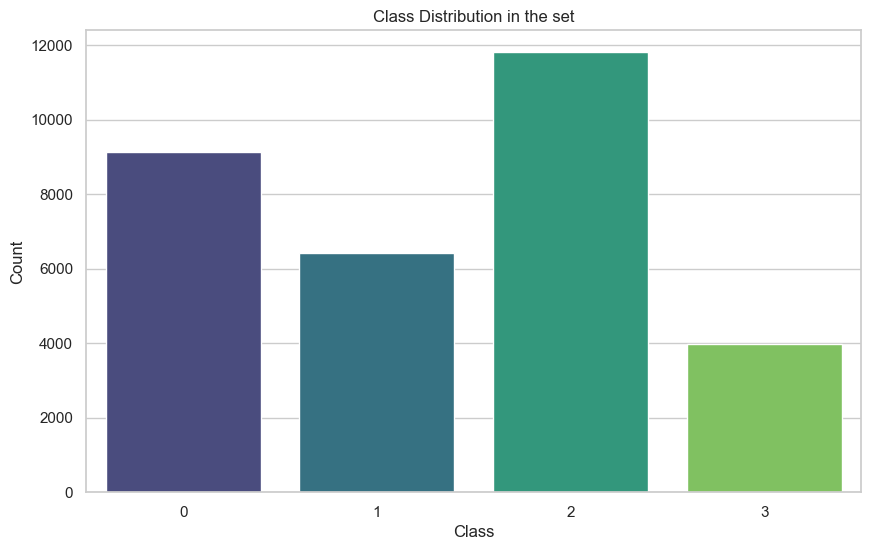

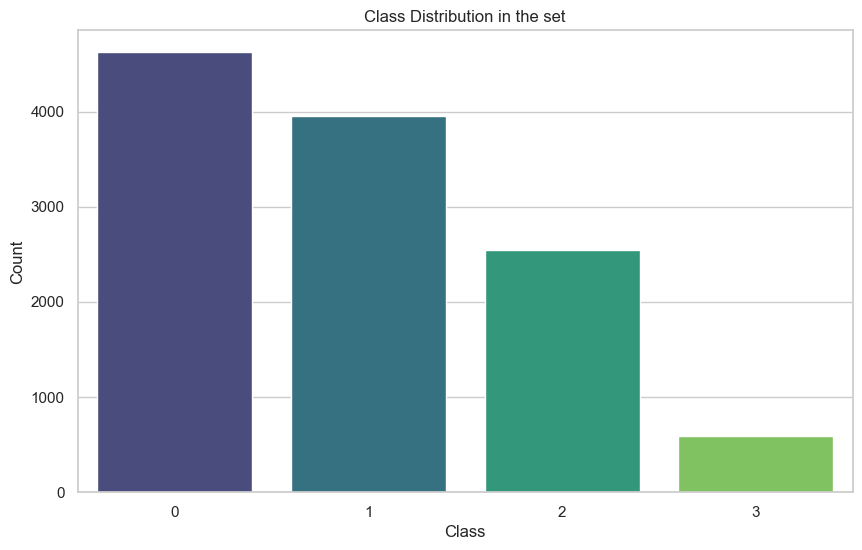

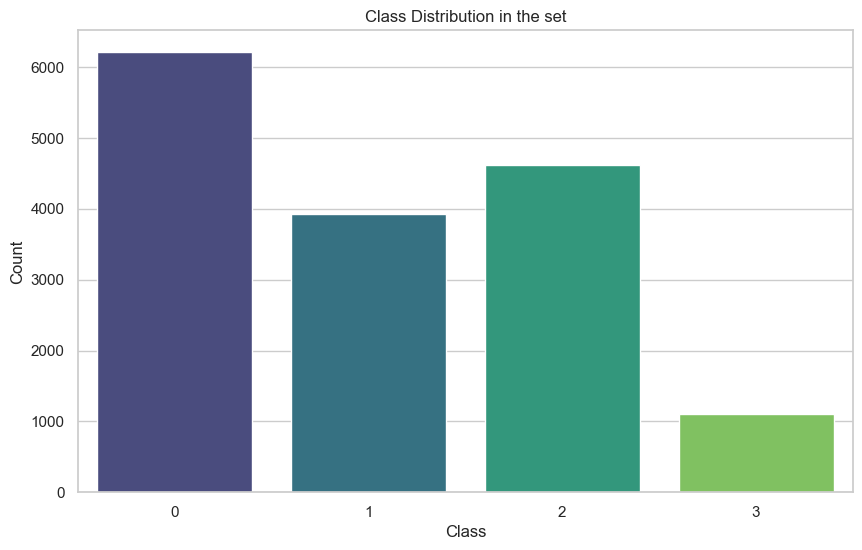

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(indices_set, split_info):
        set_labels = [split_info['labels'][index] for index in indices_set]

        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x=set_labels, palette='viridis')
        plt.title(f'Class Distribution in the set')
        plt.xlabel('Class')
        plt.ylabel('Count')

        plt.show()
        
plot_class_distribution(train_indices, split_info)
plot_class_distribution(val_indices, split_info)
plot_class_distribution(test_indices, split_info)


In [33]:
working_dir = args.working_dir_path
data_file = args.dataset_h5_path
libraries_dir = working_dir + "/libraries"

import sys
sys.path.append(working_dir)
sys.path.append("..")
# from get_sets import get_sets, get_class_weights
from data_setup import HDF5Dataset, FrameTargetDataset, split_dataset, reduce_sets
from lightning_modules.LUSModelLightningModule import LUSModelLightningModule
from lightning_modules.LUSDataModule import LUSDataModule

In [34]:

sets, split_info = get_sets(
    args.rseed,
    data_file,
    args.hospitaldict_path,
    args.train_ratio,
    args.trim_data,
    pretrained=args.pretrained
)

lus_data_module = LUSDataModule(sets["train"], 
                                sets["test"],
                                sets["val"],
                                args.num_workers, 
                                args.batch_size,
                                args.mixup)


train_weight_tensor = get_class_weights(sets["train_indices"], split_info)



image_mean: (0.12402, 0.12744, 0.13105)
image_std: (0.15992, 0.16364, 0.1696)

Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.
Split ratios: [0.6, 0.2, 0.2]

Serialized splits found, loading ...

Transforms:
Compose([
  Resize(always_apply=True, p=1, height=224, width=224, interpolation=1),
  Affine(always_apply=False, p=0.3, interpolation=1, mask_interpolation=0, cval=0, mode=0, scale={'x': (1.1, 1.25), 'y': (1.1, 1.25)}, translate_percent=None, translate_px={'x': (0, 0), 'y': (0, 0)}, rotate=(-15, 15), fit_output=False, shear={'x': (0.0, 0.0), 'y': (0.0, 0.0)}, cval_mask=0, keep_ratio=True, rotate_method='largest_box'),
  Rotate(always_apply=False, p=0.3, limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
  HorizontalFlip(always_apply=False, p=0.5),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), br

In [20]:
import matplotlib.pyplot as plt
import numpy as np

medical_center_patients, data_index, data_map_idxs_pcm, score_counts, labels = _load_dsdata_pickle(data_file, args.hospitaldict_path)
train_patients_by_center = split_info['train_patients_by_center']
val_patients_by_center = split_info['val_patients_by_center']
test_patients_by_center = split_info['test_patients_by_center']

def plot_frames_per_patient(patients_by_center, center_name):
    patients = list(patients_by_center[center_name])
    num_frames = [len(data_map_idxs_pcm[(patient, center_name)]) for patient in patients]
    
    plt.bar(np.arange(len(patients)), num_frames)
    plt.xticks(np.arange(len(patients)), patients, rotation=45)
    plt.xlabel('Patient')
    plt.ylabel('Number of Frames')
    plt.title(f'Number of Frames per Patient in {center_name}')
    plt.show()

KeyError: 'train_patients_by_center'

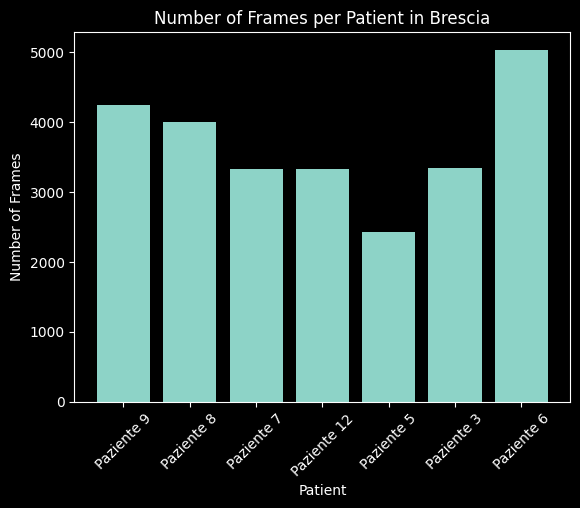

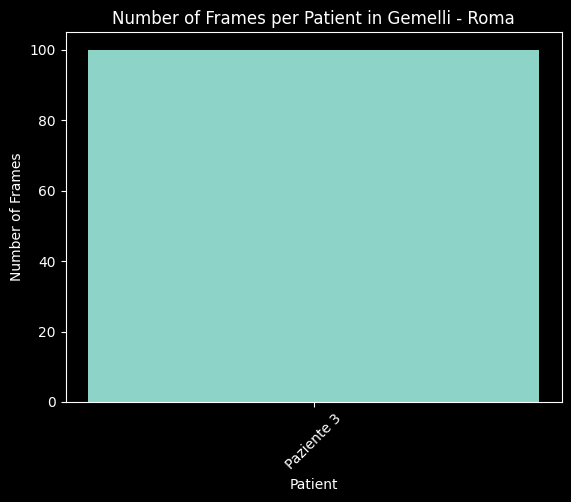

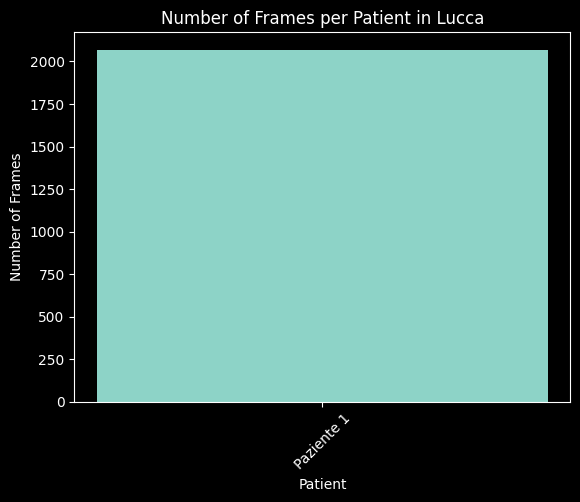

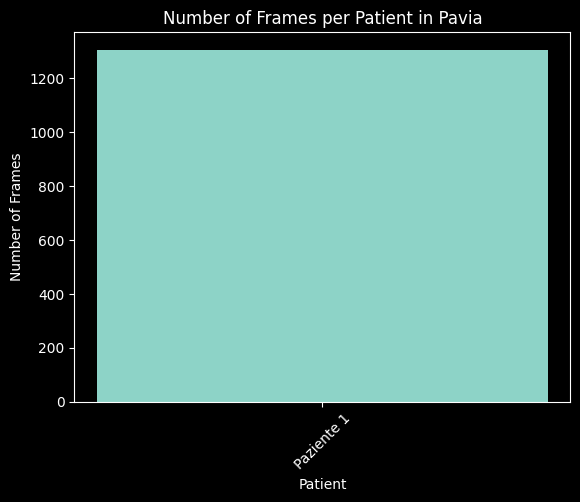

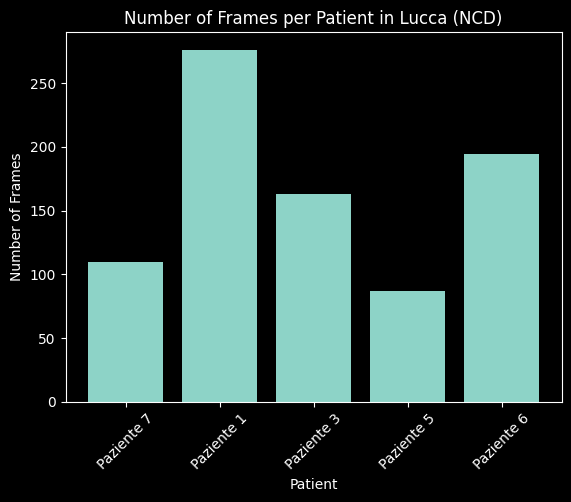

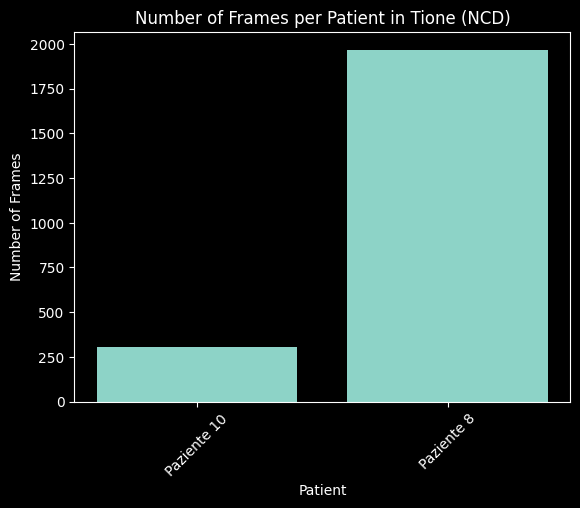

In [39]:
for center_name in train_patients_by_center.keys():
    plot_frames_per_patient(train_patients_by_center, center_name)

## Get dataset mean and standard deviation

In [8]:
device = torch.device('mps')
device

device(type='mps')

In [9]:
train_dataloader = lus_data_module.train_dataloader()
train_dataloader.shuffle = False

Use MixUp augmentation: False


In [17]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

def calculate_mean_std(dataset):
    """
    Calculate the mean and standard deviation for each channel of the dataset.

    Args:
        dataset (Dataset): The dataset for which to calculate mean and std.

    Returns:
        tuple: A tuple containing mean and std for each channel.
    """
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    channel_sum = 0.0
    channel_sum_squared = 0.0
    num_batches = 0

    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        data=data.to(device)
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        channel_sum += data.mean(2).sum(0)
        channel_sum_squared += (data ** 2).mean(2).sum(0)
        num_batches += batch_samples

    mean = channel_sum / num_batches
    std = torch.sqrt(channel_sum_squared / num_batches - mean ** 2)

    return mean.tolist(), std.tolist()

# Assuming you have created an instance of your dataset
# For example:
# my_dataset = FrameTargetDataset(hdf5_dataset, pretrained=False)

# Calculate mean and std
mean, std = calculate_mean_std(sets["train"])


In [16]:
# Round the values to four decimal places
rounded_mean = [round(value, 5) for value in mean]
rounded_std = [round(value, 5) for value in std]

print("Rounded Mean:", rounded_mean)
print("Rounded Std:", rounded_std)

Rounded Mean: [0.12664, 0.12494, 0.12254]
Rounded Std: [1.05886, 1.05655, 1.05307]


In [15]:
print(f"mean:{mean}")
print(f"std:{std}")

mean:[0.1266362965106964, 0.12493881583213806, 0.12253931909799576]
std:[1.0588585138320923, 1.0565476417541504, 1.0530682802200317]


## Batches

In [35]:
train_dataloader = lus_data_module.train_dataloader()
train_dataloader

Use MixUp augmentation: True


AttributeError: 'DataLoader' object has no attribute 'to'

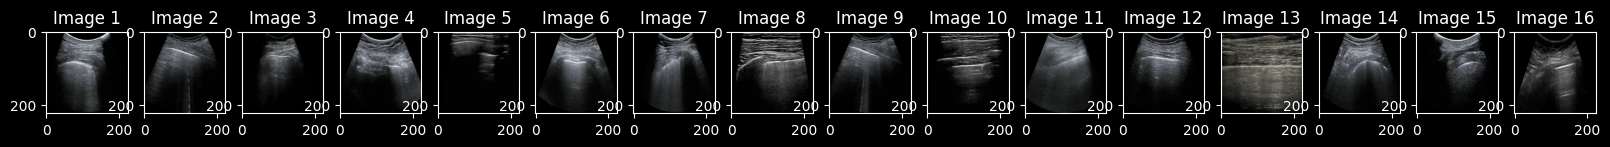

In [53]:
def show_single_batch(data_loader, batch_idx, win_size=(20, 20)):
    # Extract the specific batch by indexing the DataLoader
    for i, (imgs, labels) in enumerate(data_loader):
        if i == batch_idx:
            # Create a subplot for each image in the batch
            num_images = len(imgs)
            plt.figure(figsize=win_size)

            for j in range(num_images):
                plt.subplot(1, num_images, j + 1)
                plt.imshow(tensor_to_image(imgs[j]))  # Convert the tensor to an image
                plt.title(f"Image {j+1}")

            plt.show()
            break
# To display a specific batch (e.g., batch index 0) from the training DataLoader
show_single_batch(dataset_loader, batch_idx=6)

In [34]:
show_single_batch(train_dataloader, 1)

RuntimeError: Expected a 'mps:0' generator device but found 'cpu'

# Model

In [9]:
args_model = "botnet18"
hyperparameters = {
  "num_classes": 4,
  "optimizer": args.optimizer,
  "lr": args.lr,
  "batch_size": args.batch_size,
  "weight_decay": args.weight_decay,    
  "momentum": args.momentum,
  "label_smoothing": args.label_smoothing
}

freeze_layers = None
if args.pretrained:
    if args.freeze_layers:
        freeze_layers = args.freeze_layers
        
model = LUSModelLightningModule(model_name=args_model, 
                                hparams=hyperparameters,
                                class_weights=train_weight_tensor,
                                pretrained=args.pretrained,
                                freeze_layers=freeze_layers)

In [10]:
# -Logger configuration
version = f"V{args.version}" if args.version else "V1"
version = version.strip()

version = f"V{args.version}" if args.version else "V1"

name_version = f"_{version}"
name_trained = "_pretrained" if args.pretrained==True else ""
name_layer = f"_{args.freeze_layers}" if args.freeze_layers else ""
name_trimmed = "_trimmed" if args.trim_data else ""

model_name = f"{args_model}{name_version}{name_trained}{name_layer}{name_trimmed}/{args.optimizer}/ds_{args.train_ratio}_lr{args.lr}_bs{args.batch_size}"
logger = TensorBoardLogger("tb_logs", name=model_name, version=version)
# -Checkpointing
#   Checkpoints directory
checkpoint_dir = f"{working_dir}/checkpoints/{model_name}"
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dir, 
                                      save_top_k=1,
                                      mode="min",
                                      monitor="validation_loss",
                                      save_last=True,
                                      save_on_train_epoch_end=False,
                                      verbose=True,
                                      filename="{epoch}-{validation_loss:.4f}")


In [11]:
from lightning.pytorch.callbacks import LearningRateFinder
class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)
            
LRFinder = FineTuneLearningRateFinder(milestones=(5, 10)) 


In [12]:
early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)


In [13]:
callbacks = [
            # DeviceStatsMonitor(),
            LearningRateMonitor(),
            early_stop_callback,
            checkpoint_callback,
            LRFinder
            ]

In [14]:
# Trainer args
trainer_args = {
    "max_epochs": args.max_epochs,
    "callbacks": callbacks,
    "precision": args.precision,
    "accumulate_grad_batches": args.accumulate_grad_batches,
    "logger": logger
}
# Trainer 
trainer = Trainer(**trainer_args,
                #   detect_anomaly=True,
                #   overfit_batches=0.01,
                #   val_check_interval=0.25,
                #   gradient_clip_val=0.1,
                    # benchmark=True,
                    accelerator=accelerator,
                    default_root_dir = checkpoint_dir)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
 trainer.fit(model, lus_data_module)


  | Name            | Type               | Params
-------------------------------------------------------
0 | model           | BotNet             | 8.1 M 
1 | train_criterion | CrossEntropyLoss   | 0     
2 | test_criterion  | CrossEntropyLoss   | 0     
3 | transform       | DataAugmentation   | 0     
4 | train_f1        | MulticlassF1Score  | 0     
5 | val_f1          | MulticlassF1Score  | 0     
6 | test_f1         | MulticlassF1Score  | 0     
7 | train_acc       | MulticlassAccuracy | 0     
8 | val_acc         | MulticlassAccuracy | 0     
9 | test_acc        | MulticlassAccuracy | 0     
-------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.258    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Use MixUp augmentation: True


Training: 0it [00:00, ?it/s]

In [ ]:
model.hparams

"freeze_layers": None
"hparams":       {'num_classes': 4, 'optimizer': 'sgd', 'lr': 0.0004, 'batch_size': 16, 'weight_decay': 0.0001, 'momentum': 0.9, 'label_smoothing': 0.1}
"model_name":    betnet18
"pretrained":    False